# Creating and simulating a DFBA model
This tutorial demonstrates how to build and simulate a DFBA model corresponding to the growth of a single strain of _Escherichia coli_ (based on the iJR904 genome-scale model) under aerobic and anaerobic conditions with glucose and xylose as limiting carbon substrates. The simulation is loosely based on the following paper:

> Hanly, T.J. and Henson, M.A. (2011), Dynamic flux balance modeling of microbial co‐cultures for efficient batch fermentation of glucose and xylose mixtures. Biotechnol. Bioeng., 108: 376-385. [doi:10.1002/bit.22954](https://doi.org/10.1002/bit.22954)

This notebook was adapted with minor changes from the [dfba documentation](https://dynamic-fba.readthedocs.io/en/latest/example1.html).

In [1]:
from os.path import dirname, join, pardir

from cobra.io import read_sbml_model

from dfba import DfbaModel, ExchangeFlux, KineticVariable

## 1. Dfba model
A model will be build as the following ODE system:
\begin{align}
    \frac{dX}{dt} &= v_{BM}X \\
    \frac{dC_j}{dt} &= v_jX
\end{align}

where $X$ is the Biomass (_gDW_); $v$ is the flux of a exchange reaction $j$ (_mmol/gDW/h_) or the exchange biomass reaction $BM$ (_g/gDW/h_, to measure growth). 

First off, specify the path for loading file containing genome-scale metabolic model as [cobra.Model](https://cobrapy.readthedocs.io/en/latest/building_model.html) object and set GLPK as LP solver of choice. After that, instantiate the object of class `DfbaModel` with the cobrapy model.

In [3]:
%%capture --no-display
fba_model = read_sbml_model("../data/iJR904.xml.gz")
fba_model.solver = "glpk"
dfba_model = DfbaModel(fba_model)

## 2. Kinetic Variables
For this example, the metabolites $j$ in the medium will be **Glucose, Xylose, Oxygen and Ethanol**. Later, we will establish the kinetic rules for the uptakes of these metabolites. In addition, we need to set a variable to keep track of the **biomass**.

Instantiate kinetic variables to appear in model. The last command adds the kinetic variables to the model.

In [4]:
X = KineticVariable("Biomass")
Gluc = KineticVariable("Glucose")
Xyl = KineticVariable("Xylose")
Oxy = KineticVariable("Oxygen")
Eth = KineticVariable("Ethanol")

dfba_model.add_kinetic_variables([X, Gluc, Xyl, Oxy, Eth])

## 3. Exchange fluxes
Instantiate exchange fluxes to appear in model, with ids corresponding to exchange reactions of the cobrapy model. The last command adds the exchange fluxes to the model.

In [5]:
mu = ExchangeFlux("BiomassEcoli")
v_G = ExchangeFlux("EX_glc(e)")
v_Z = ExchangeFlux("EX_xyl_D(e)")
v_O = ExchangeFlux("EX_o2(e)")
v_E = ExchangeFlux("EX_etoh(e)")

dfba_model.add_exchange_fluxes([mu, v_G, v_Z, v_O, v_E])

## 4. Rhs expressions 
Provide symbolic expression for calculating the time derivative of each kinetic variable currently in the model. See how these correspond to our ODE system.
\begin{align}
    \frac{dX}{dt} &= v_{BM}X \\
    \frac{dC_j}{dt} &= v_jX
\end{align}

In [6]:
dfba_model.add_rhs_expression("Biomass", mu * X)
dfba_model.add_rhs_expression("Glucose", v_G * 180.1559/1000 * X) # v_G [mmol gDW^-1 h^-1] * 0.18 g/mmol * gDW/L
dfba_model.add_rhs_expression("Xylose", v_Z * 150.13/1000 * X)
dfba_model.add_rhs_expression("Oxygen", 0) # O2 is kept constant
dfba_model.add_rhs_expression("Ethanol", v_E * 46.06844/1000 * X)

## 5. Lower/upper bound expressions 
Add symbolic expressions for calculating lower/upper bounds of selected exchange fluxes
currently in the model. Here, the convention is that both lower and upper bound expressions have 
positive signs, whereas lower bounds values are typically negative in cobrapy. 

Here, the lower bounds will follow a Michaelis-Menten kinetics:

$$
lb = - \frac{C_jV_{max}}{ C_j + K_m}
$$

(The Kinetic parameters $V_{max}$ and $K_m$ can be found in the literature for the given exchange reactions)

In [7]:
vmax_o2 = 15 # [mmol gDW^-1 h^-1]
Ko = 0.024 # mmol/L O2 Michaelis-Mentent constant
dfba_model.add_exchange_flux_lb("EX_o2(e)", vmax_o2 * (Oxy / (Ko + Oxy)), Oxy)

But we are not limited to this formula! Let's say Glucose is inhibited by Ethanol.

In [8]:
vmax_glc = 10.5 # [mmol gDW^-1 h^-1]
Kg = 0.0027 # g/L Glucose Michaelis-Mentent constant
Kie = 20 # g/L Ethanol inhibition constant
dfba_model.add_exchange_flux_lb(
    "EX_glc(e)",
    vmax_glc * (Gluc / (Kg + Gluc)) * (1 / (1 + Eth / Kie)),
    Gluc
)

And Xylose in inhibited by both Ethanol and Glucose

In [9]:
vmax_xyl = 6 # [mmol gDW^-1 h^-1]
Kz = 0.0165 # g/L Glucose Michaelis-Mentent constant
Kie = 20 # g/L Ethanol inhibition constant
Kig = 0.005 # g/L Glucose inhibition constant
dfba_model.add_exchange_flux_lb(
    "EX_xyl_D(e)",
    vmax_xyl * (Xyl / (0.0165 + Xyl)) * (1 / (1 + Eth / Kie)) * (1 / (1 + Gluc / 0.005)),
    Xyl,
)

## 6. Add initial conditions to the model and launch the simulation.
Initial values for each kinetic variable are provided in dictionary form. 

The model is simulated using the `simulate` method. This simulation covers the interval $[0.0, 25.0]$ hours, with results stored every $0.1$ hours. Results (trajectories of kinetic variables) will be returned as [pandas.DataFrame](https://pandas.pydata.org/). Optionally, the user can also provide a list of reaction ids whose flux trajectories will also be returned as a separate [pandas.DataFrame](https://pandas.pydata.org/), in this case three exchange fluxes in the model.

In [10]:
dfba_model.add_initial_conditions(
    {
        "Biomass": 0.01, # (gDW/L)
        "Glucose": 15.5, # (g/L)
        "Xylose": 8.0,   # (g/L)
        "Oxygen": 0.24,  # (mmol/L)
        "Ethanol": 0.0,  # (g/L)
    }
)
concentrations, trajectories = dfba_model.simulate(0.0, 25.0, 0.1, ["EX_glc(e)", "EX_xyl_D(e)", "EX_etoh(e)"])

## 7. Plotting the results
<div class="alert alert-info">

**Note:** In order plot the results, one of [plotly](https://plot.ly/python/) or [matplotlib](https://matplotlib.org/) must be used. Check the [original example in the documentation](https://dynamic-fba.readthedocs.io/en/latest/example1.html#Matplotlib) to see the matplotlib counterpart.

</div>

In [11]:
# from dfba.plot.plotly import *
from dfba.plot.matplotlib import *

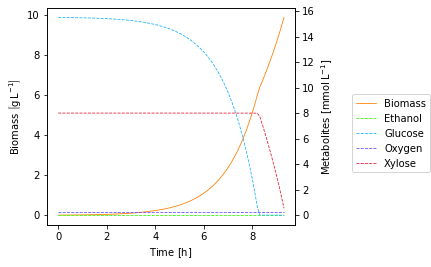

In [12]:
plot_concentrations(concentrations)

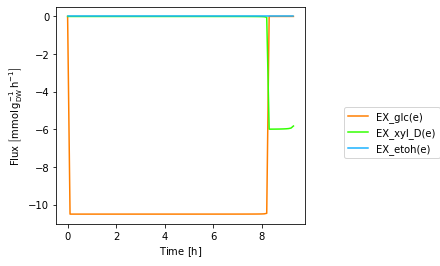

In [13]:
plot_trajectories(trajectories)

## Exercises
1. Add a death rate $\delta$ to the model.
    $$
    \frac{dX}{dt} = v_{BM}X - \delta X
    $$
2. Run under anaerobic conditions from the start.
3. Try to change xylose with another carbon source, can you add a refreshment $\epsilon$ to this carbon source?
    $$
    \frac{dC_j}{dt} = v_{j}X + \epsilon
    $$
4. Can you adapt the simulation to facilitate the re-uptake of Ethanol?

<div class="alert alert-warning">

**Note:** The dfba package seems to have an issue with re-running cells leading to simulations sometimes to fail. We recommned creating a separate notebook for each exercise task and run cells there from top to bottom after restarting the notebook kernel to avoid those problems. Alternatively, you could create simple Python scripts for each tasks.

</div>